In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/s_peel9.json"

dict_keys(['test_loss', 'test_plcc', 'test_srcc', 'test_mae', 'train_loss', 'train_plcc', 'train_srcc', 'train_mae', 'eval_plcc', 'eval_srcc', 'eval_mae', 'eval_preds', 'eval_epoch'])


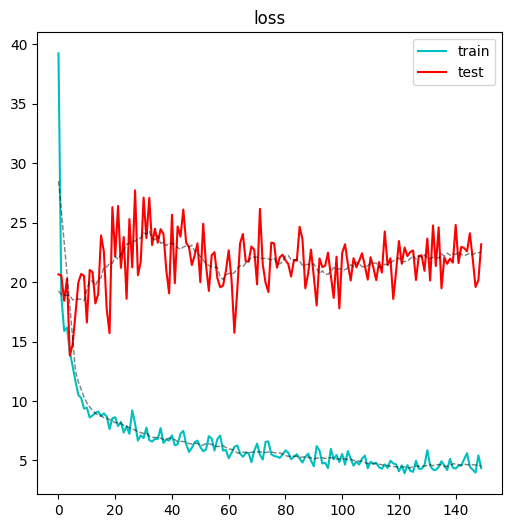

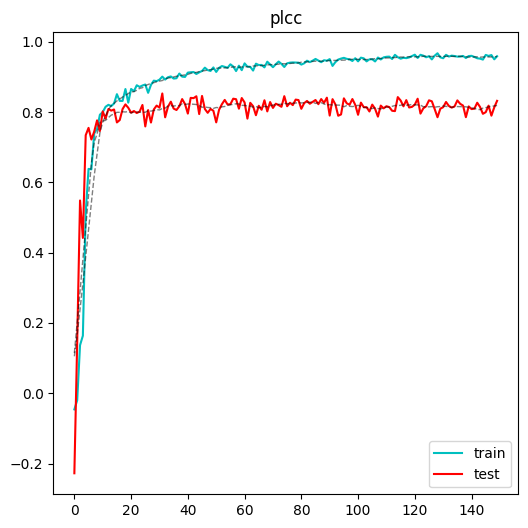

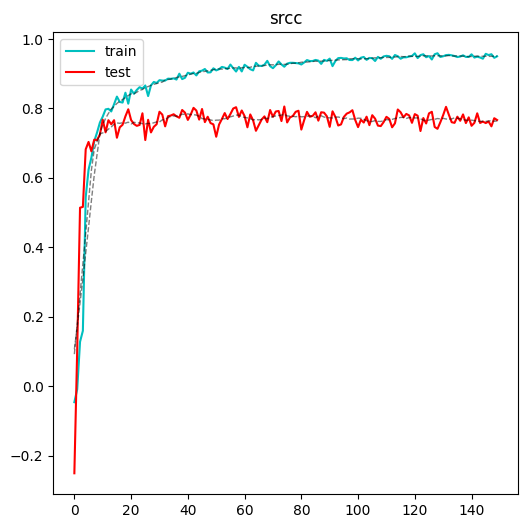

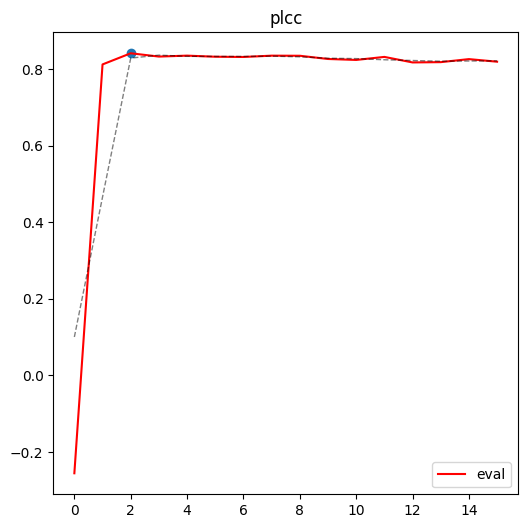

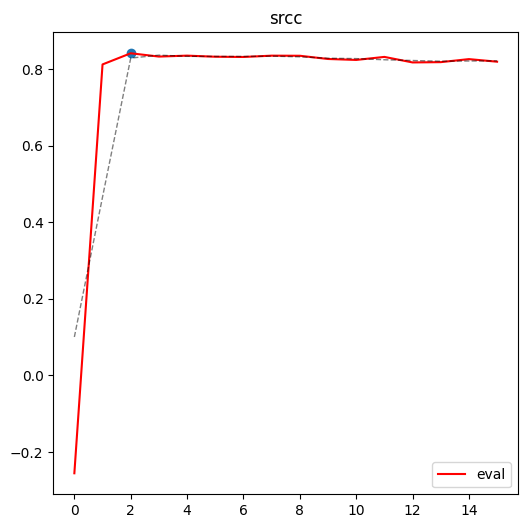

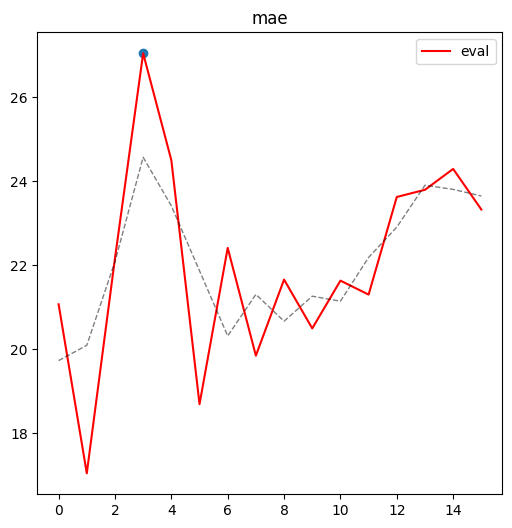

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import List

with open(path, 'r') as fr:
    stats = json.load(fr)
print(stats.keys())

s = (6,6)

def moving_average(x:List, w:int):
    pad_width = w // 2
    x_padded = np.pad(x, pad_width, mode='edge')
    return np.convolve(x_padded, np.ones(w)/ w, 'valid') 

def drawPlot(test:List, train:List, trainLbl:str, testLbl:str, title:str, size=(6,6)):
    epochCount = np.arange(len(test))
    plt.figure(figsize=size)
    plt.plot(epochCount,train, label=trainLbl, color="c")
    plt.plot(epochCount,test, label=testLbl, color="r")
    w =11
    train_avg = moving_average(train, w)
    test_avg = moving_average(test,w)
    plt.plot(epochCount,train_avg, color="k", alpha=0.5, linestyle='--', linewidth=1)
    plt.plot(epochCount,test_avg, color="k", alpha=0.5, linestyle='--', linewidth=1)
    plt.title(title)
    plt.legend()
    plt.show()

def drawPlotSingle(data:List, label:str, title:str, size=(6,6), x:List = None):
    data:np.ndarray = np.array(data)
    bestIndex = data.argmax()

    if(x == None):
        epochCount = np.arange(len(data))
    else:
        epochCount = np.array(x)

    # print(len(epochCount), len(data))
    # if(len(epochCount) > len(data)):
    #     data = data[0:-2]
    # print(len(epochCount), len(data)) 
    plt.figure(figsize=size)
    plt.plot(epochCount,data, label=label, color="r")
    data_avg = moving_average(data,3)
    plt.plot(epochCount,data_avg, color="k", alpha=0.5, linestyle='--', linewidth=1)
    plt.scatter([epochCount[bestIndex]], [data[bestIndex]])
    plt.title(title)
    plt.legend()
    plt.show()


test = stats["test_loss"]
train = stats["train_loss"]

drawPlot(test,train, "train", "test", "loss",s)


test = stats["test_plcc"]
train = stats["train_plcc"]

drawPlot(test,train, "train", "test", "plcc",s)

test = stats["test_srcc"]
train = stats["train_srcc"]

drawPlot(test,train, "train", "test", "srcc",s)


plcc = stats["eval_plcc"]
srcc = stats["eval_srcc"]
mae = stats["eval_mae"]

drawPlotSingle(plcc, "eval", "plcc",s)
drawPlotSingle(srcc, "eval", "srcc",s)
drawPlotSingle(mae, "eval", "mae",s)


In [6]:

from helpersmag.trainingUtils import prepareDataset
from types import SimpleNamespace
initData = SimpleNamespace()
initData.seed = 2137
initData.dataset = "clive"
initData.dataset_normalized = False
_, testDataset = prepareDataset(initData,None,None)
# for index, (img, lbl) in enumerate(testDataset):
#     print(lbl.item())
#     break

lbls = np.array([lbl.item() for index, (img, lbl) in enumerate(testDataset)])
lbls.shape

(233,)

In [12]:
import pandas as pd
from helpersmag.trainingUtils import prepareDataset
from types import SimpleNamespace
from typing import Dict
from helpersmag.accuracy import calc_SRCC, calc_PLCC, calc_MAE
import torch

def plotres(srcc:List[float], preds:List[List[float]], initData:Dict[str,any]=None, index:int = None):
    if(index == None):
        index = np.array(srcc).argmax()
    # Wczytaj dane bez nagłówka i nadaj własne nazwy kolumn

    if(initData):
        initData = SimpleNamespace(**initData)
    else:
        initData = SimpleNamespace()
        initData.seed = 2137
        initData.dataset = "clive"
        initData.dataset_normalized = False
    _, testDataset = prepareDataset(initData,[],[])



    # Przekształć kolumny na listy
    pred = preds[index]
    lbl = [lbl.item() for index, (img, lbl) in enumerate(testDataset)]
    indexes = np.arange(0,100,1)
    pred = np.array(pred)
    lbl = np.array(lbl)

    pred = torch.tensor(pred)
    lbl = torch.tensor(lbl)
    print("SRCC ", calc_SRCC(pred,lbl), " PLCC ", calc_PLCC(pred,lbl), calc_MAE(pred,lbl))
    pred = pred * 10
    # print("SRCC ", calc_SRCC(pred,lbl), " PLCC ", calc_PLCC(pred,lbl), calc_MAE(pred,lbl))
    # # pred = pred * -1.6 - 40

    reg1 = np.poly1d(np.polyfit(lbl, pred, deg=1))(indexes)
    reg2 = np.poly1d(np.polyfit(lbl, pred, deg=2))(indexes)

    # Wyświetl dane


    plt.figure()
    plt.scatter(lbl, pred)
    plt.plot(indexes,reg1,color="k", alpha=0.5, linestyle='--', linewidth=1)
    plt.plot(indexes,reg2,color="c", alpha=0.5, linestyle='--', linewidth=1)
    plt.xlabel("target")
    plt.ylabel("pred")
    plt.plot(indexes, color="b")

    pred = torch.tensor(pred)
    lbl = torch.tensor(lbl)

def showRes(path):
    with open(path, 'r') as fr:
        stats = json.load(fr)

    test = stats["test_loss"]
    train = stats["train_loss"]

    drawPlot(test,train, "train", "test", "loss",s)


    test = stats["test_plcc"]
    train = stats["train_plcc"]

    drawPlot(test,train, "train", "test", "plcc",s)

    test = stats["test_srcc"]
    train = stats["train_srcc"]

    drawPlot(test,train, "train", "test", "srcc",s)


    plcc = stats["eval_plcc"]
    srcc = stats["eval_srcc"]
    mae = stats["eval_mae"]
    epochs = stats["eval_epoch"]

    drawPlotSingle(plcc, "eval", "plcc",s, x=epochs)
    drawPlotSingle(srcc, "eval", "srcc",s, x=epochs)
    drawPlotSingle(mae, "eval", "mae",s, x=epochs)

    bestIndex = np.array(srcc).argmax()

    preds = stats["eval_preds"]
    initData = stats["init_data"]
    plotres(srcc,preds,initData)
    print( f"Best  srcc:{np.array(srcc)[bestIndex]} plcc:{np.array(plcc)[bestIndex]}")

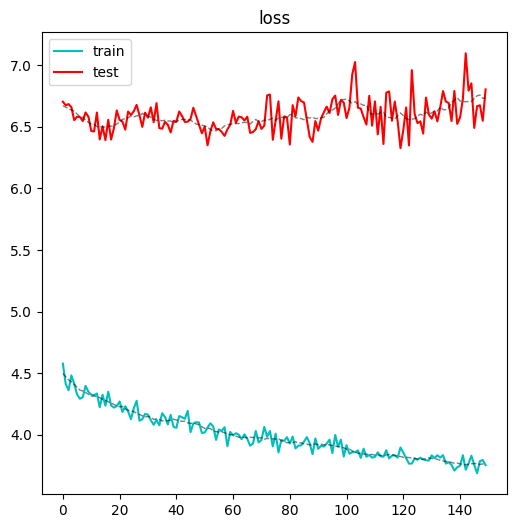

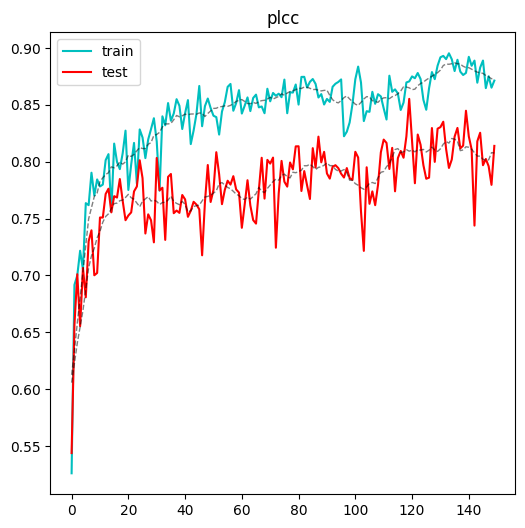

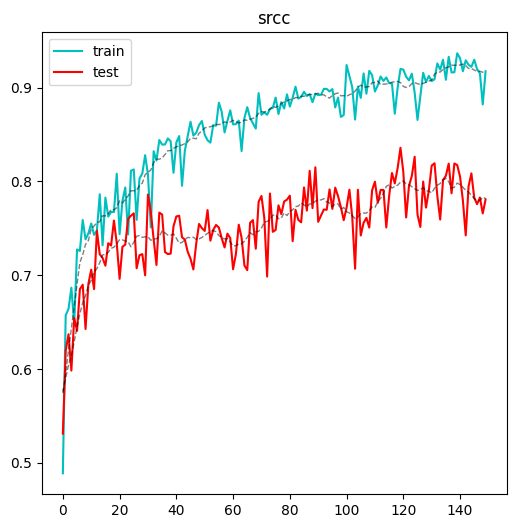

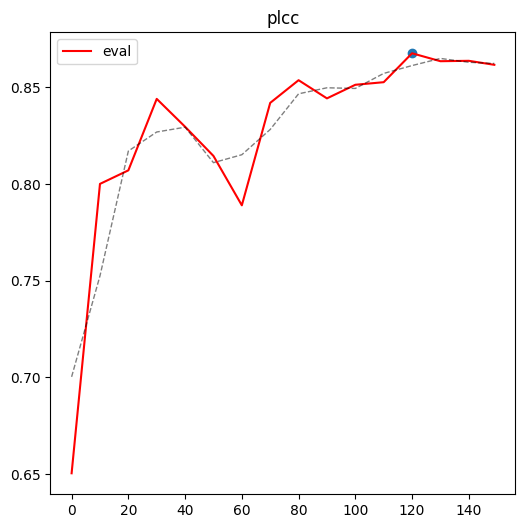

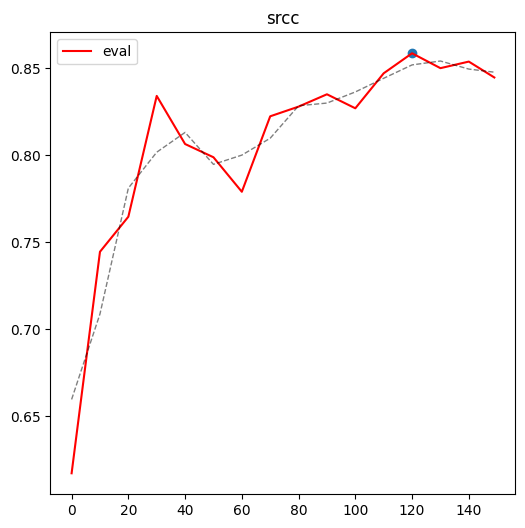

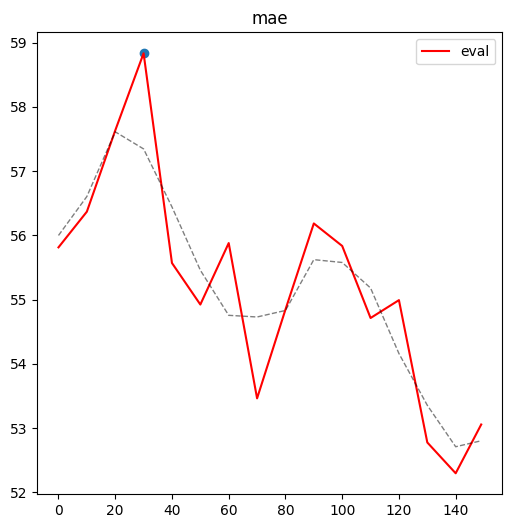

SRCC  tensor(0.8587)  PLCC  tensor(0.8677, dtype=torch.float64) tensor(54.9906, dtype=torch.float64)
Best  srcc:0.8587049245834351 plcc:0.8676905632019043


/tmp/ipykernel_135763/3405786926.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred)
/tmp/ipykernel_135763/3405786926.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lbl = torch.tensor(lbl)


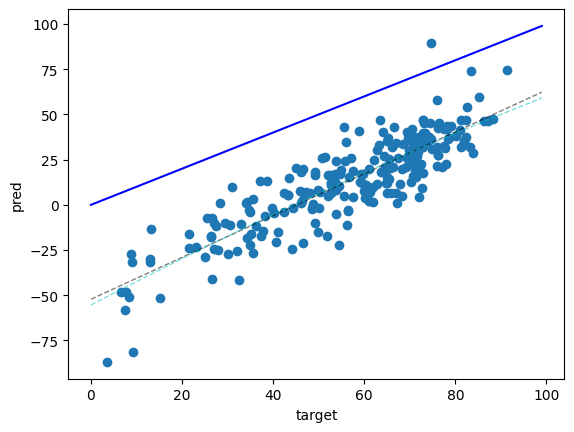

In [13]:
showRes("/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/Tres_clive_2048686115652199739.json")

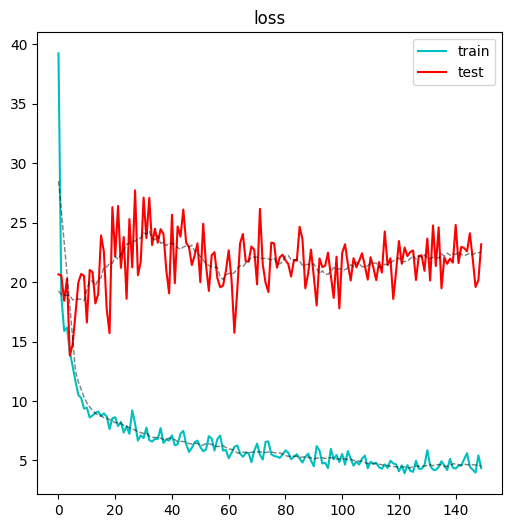

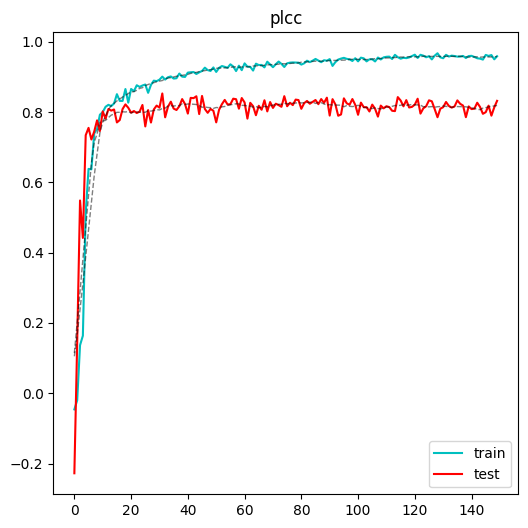

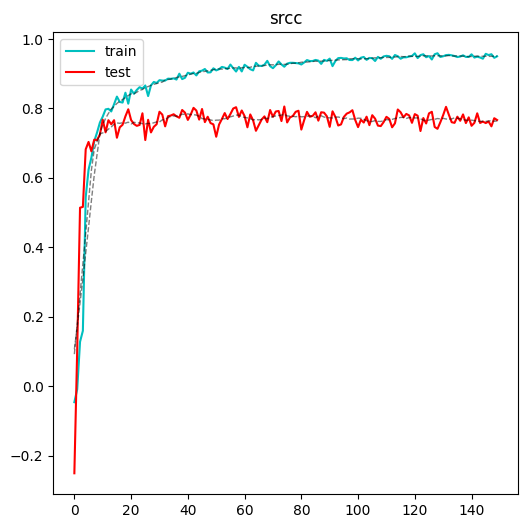

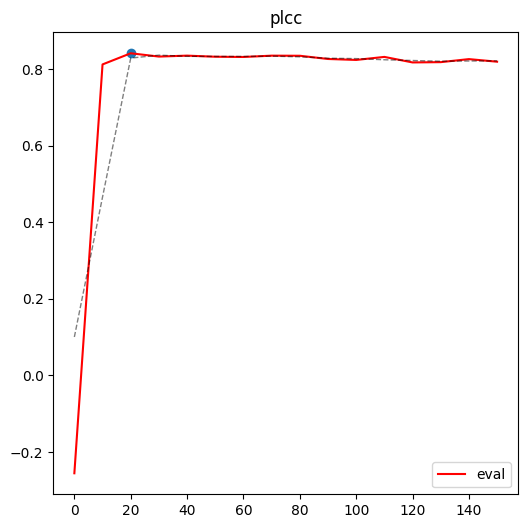

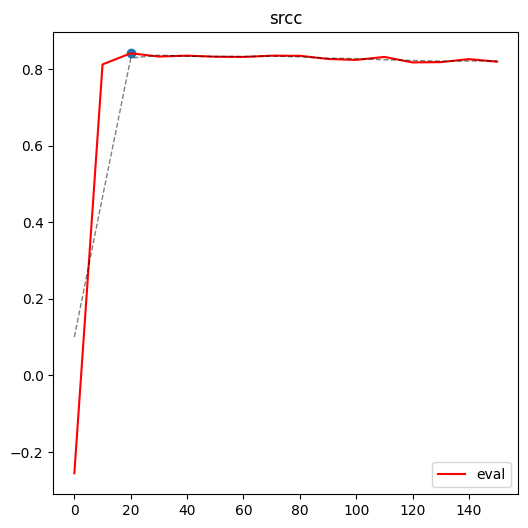

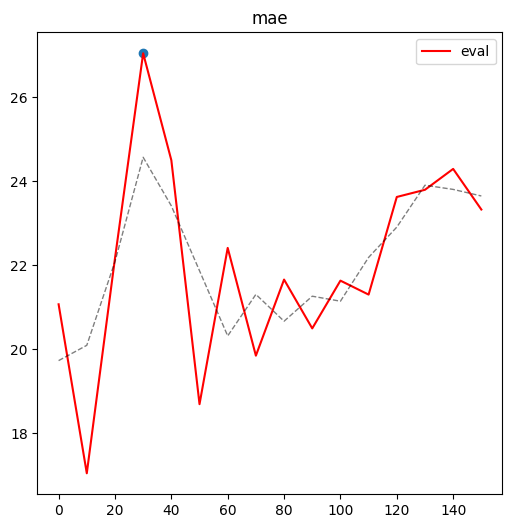

Best  srcc:0.8415185809135437 plcc:0.8415185809135437


In [47]:
showRes(path)

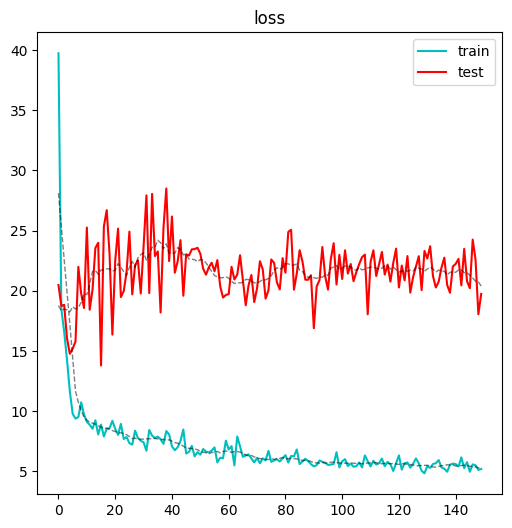

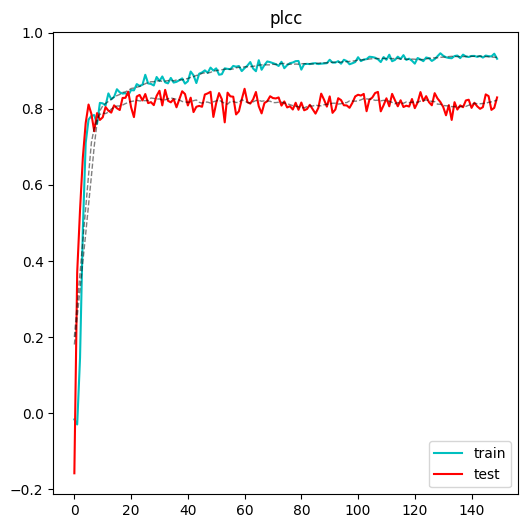

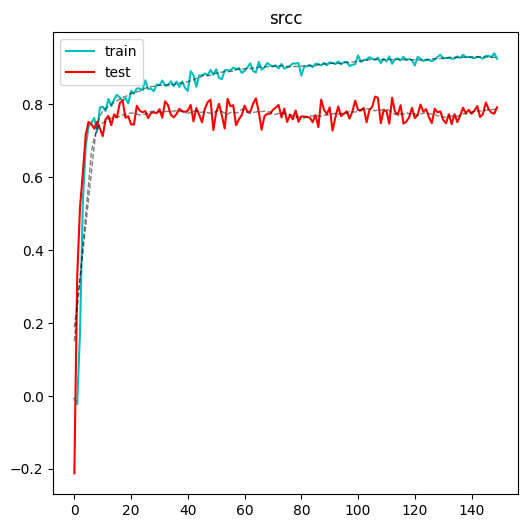

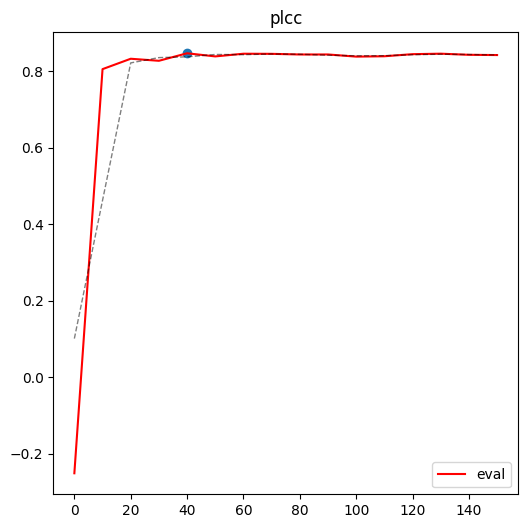

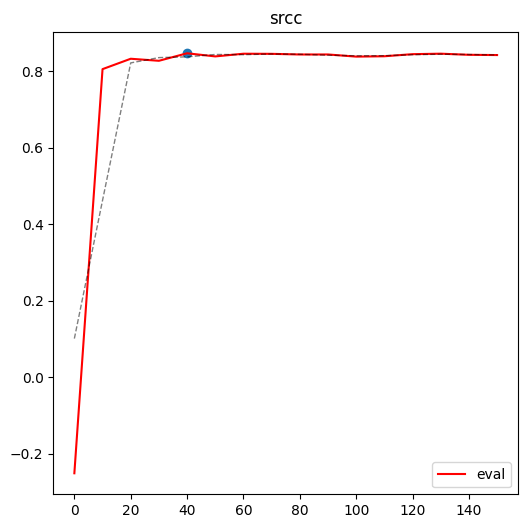

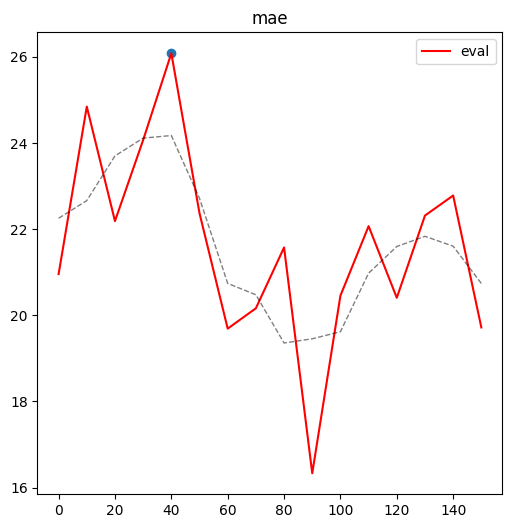

Best  srcc:0.8473852276802063 plcc:0.8473852276802063


In [42]:
path2 = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/s_peel7.json"

showRes(path2)

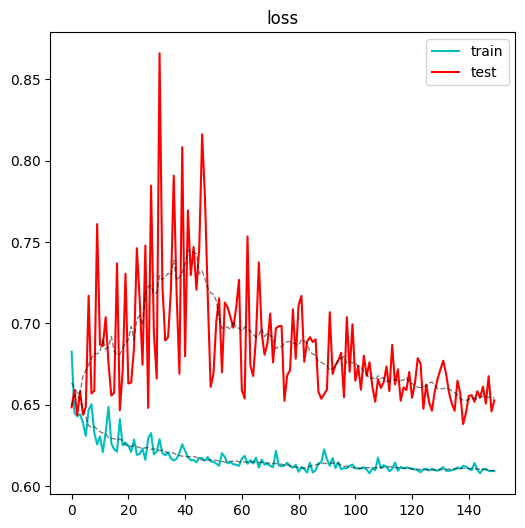

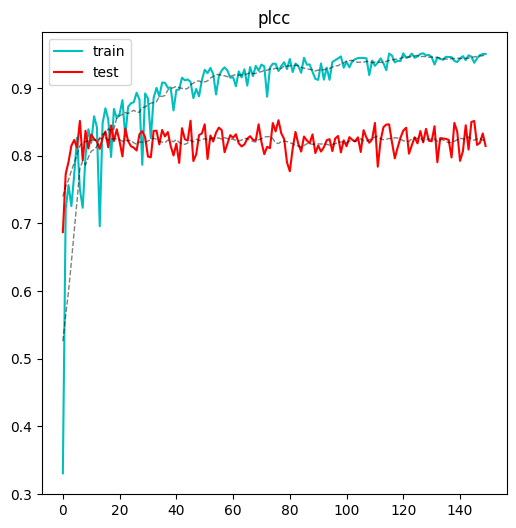

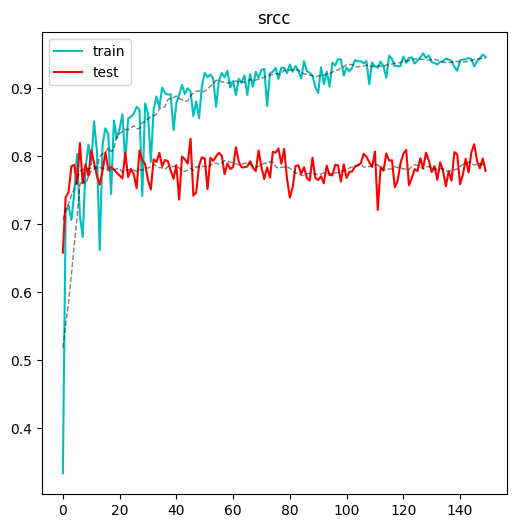

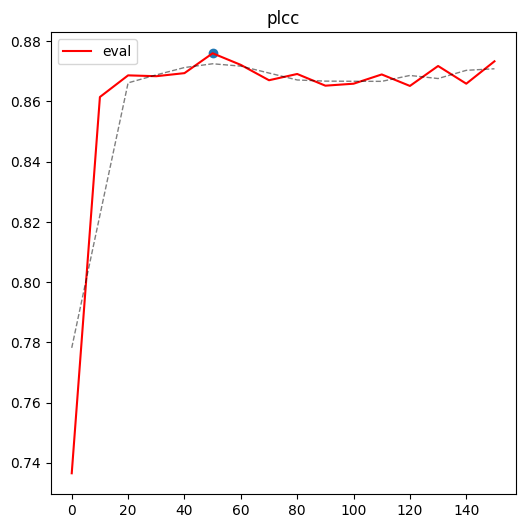

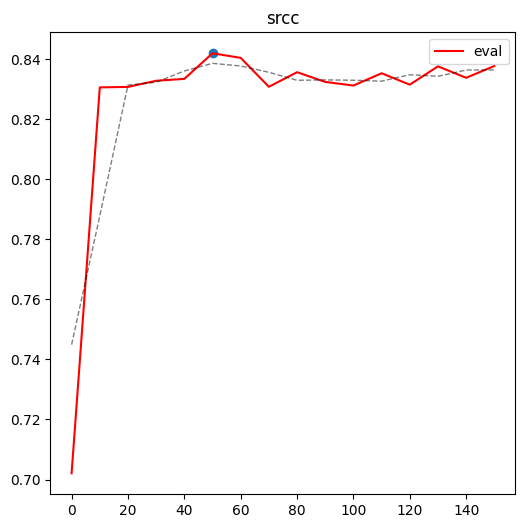

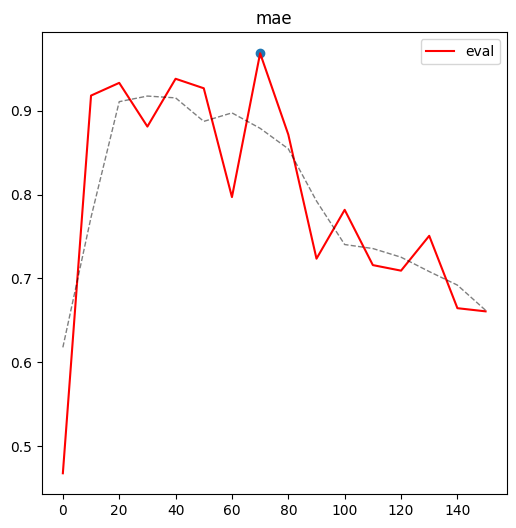

Best  srcc:0.8419056534767151 plcc:0.8760105967521667


In [43]:
path3 = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/s_peel10.json"

showRes(path3)

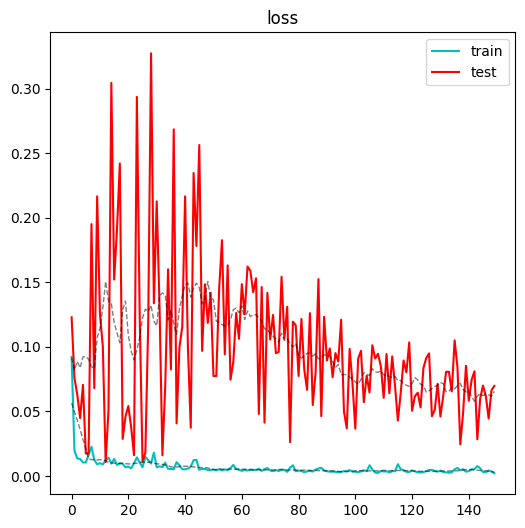

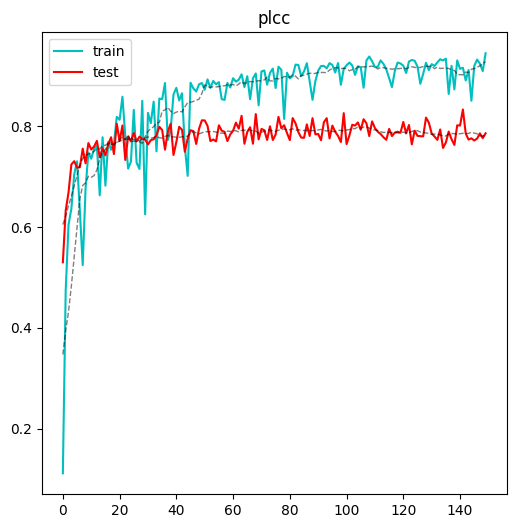

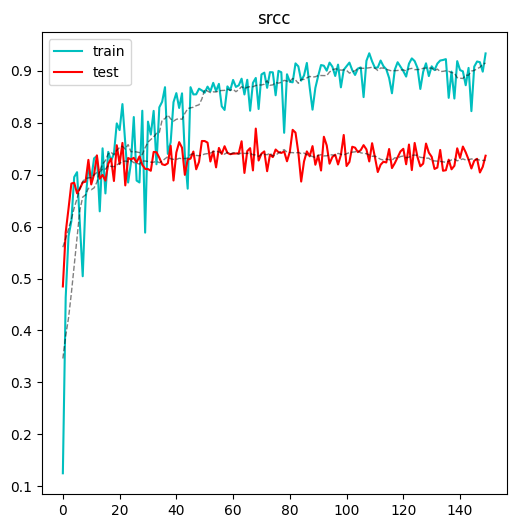

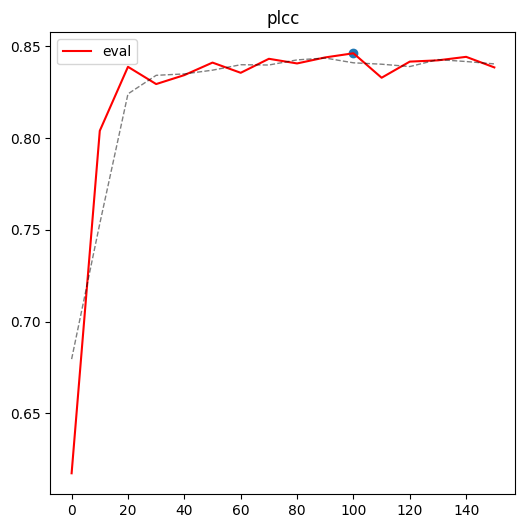

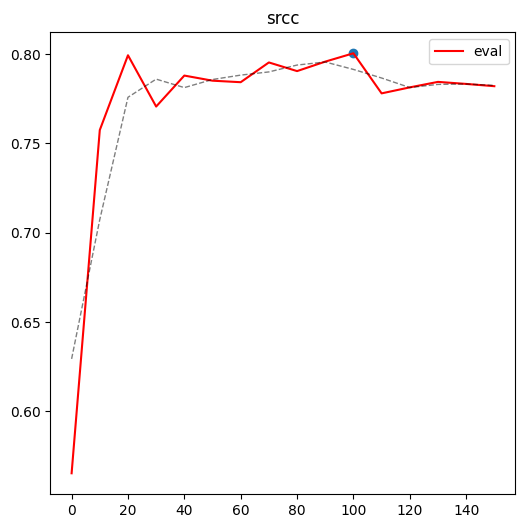

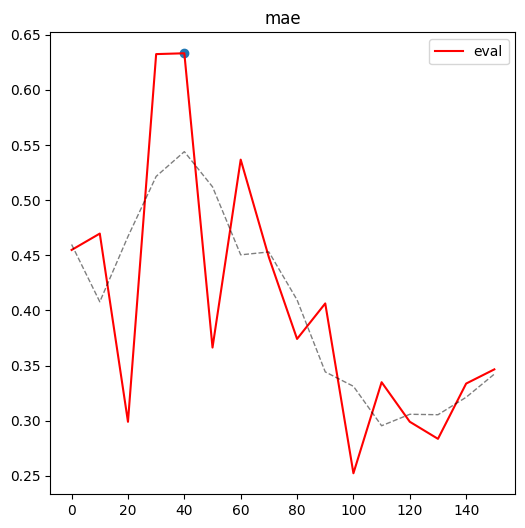

Best  srcc:0.8004841804504395 plcc:0.8462694883346558


In [44]:
path11 = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/s_peel11.json"
showRes(path11)

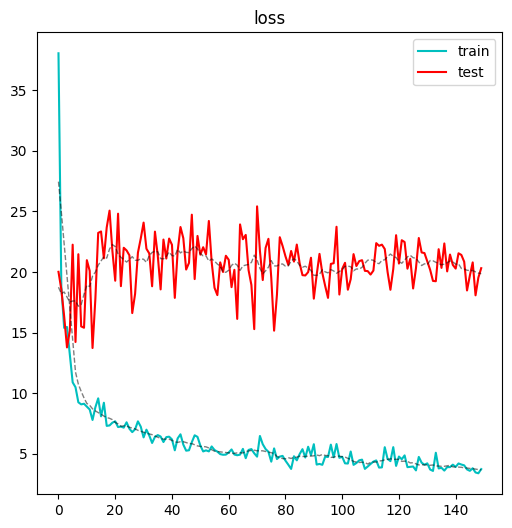

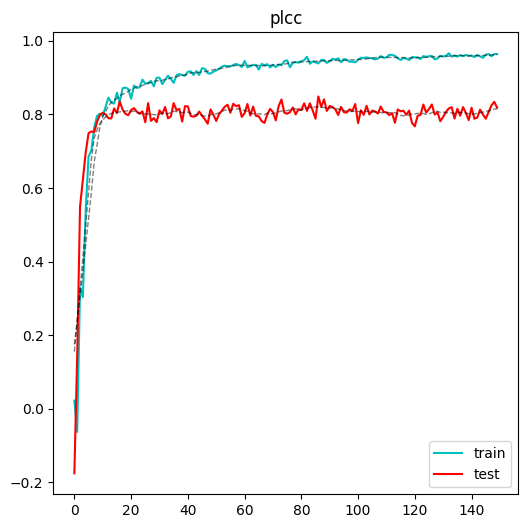

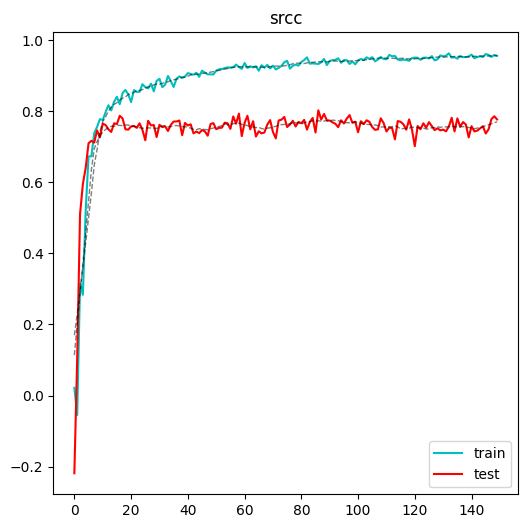

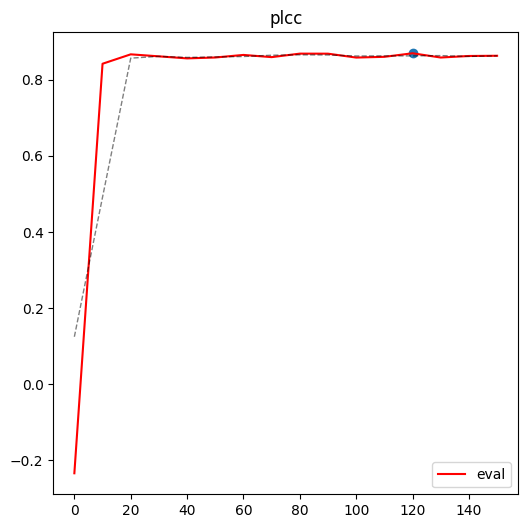

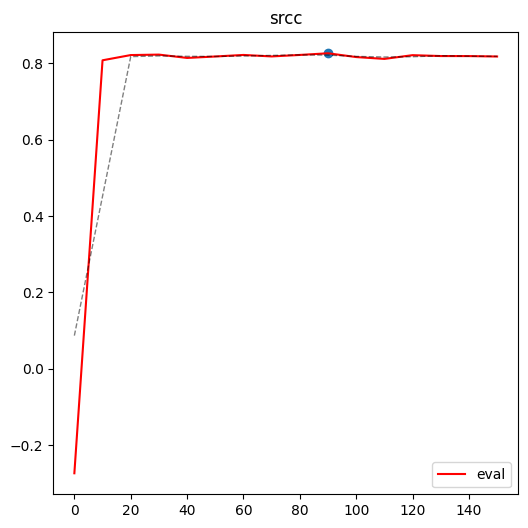

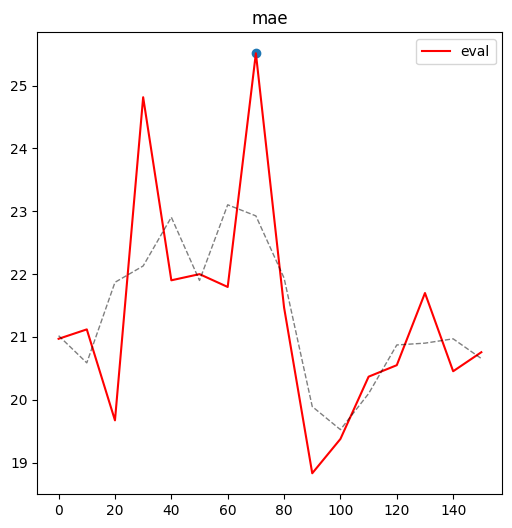

Best  srcc:0.8261783719062805 plcc:0.8686569929122925


In [45]:
path12 = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/s_peel12.json"
showRes(path12)

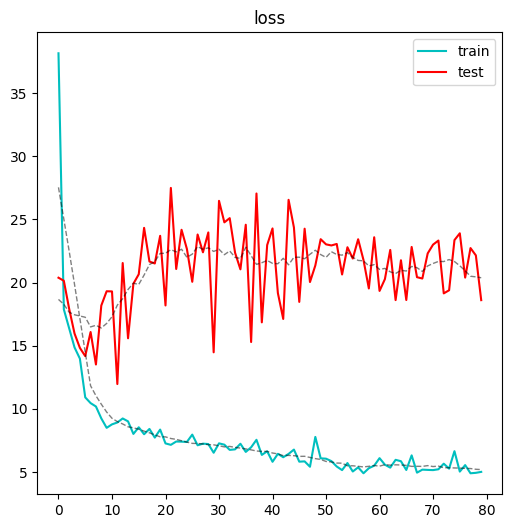

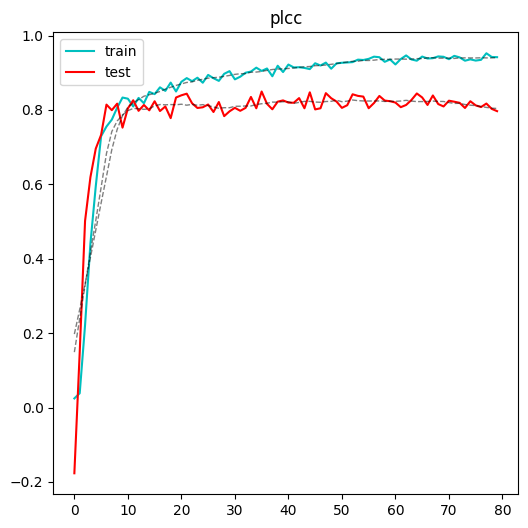

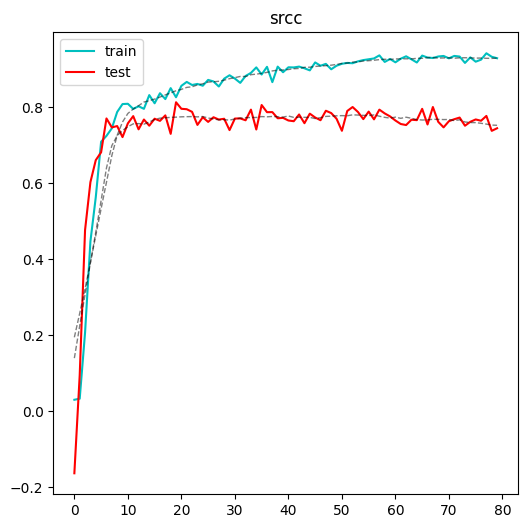

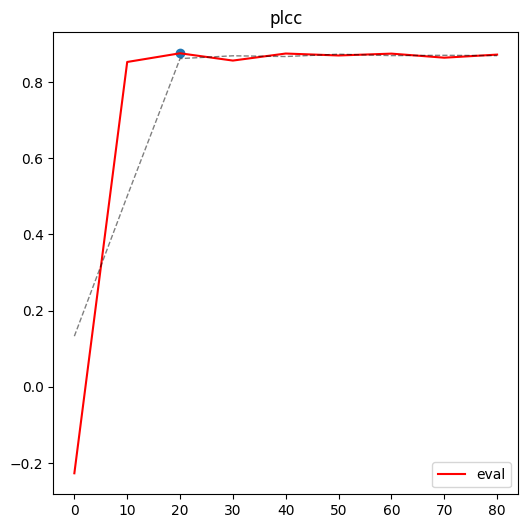

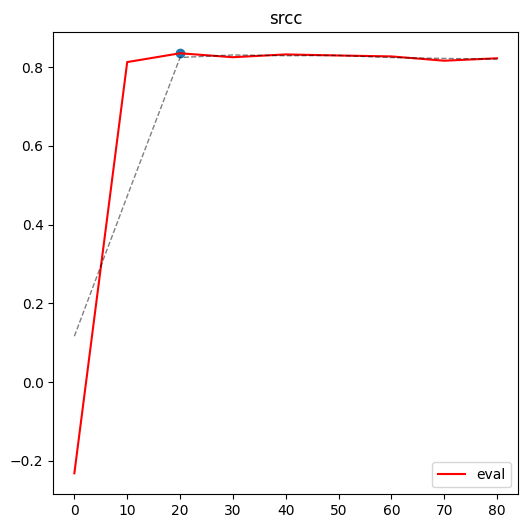

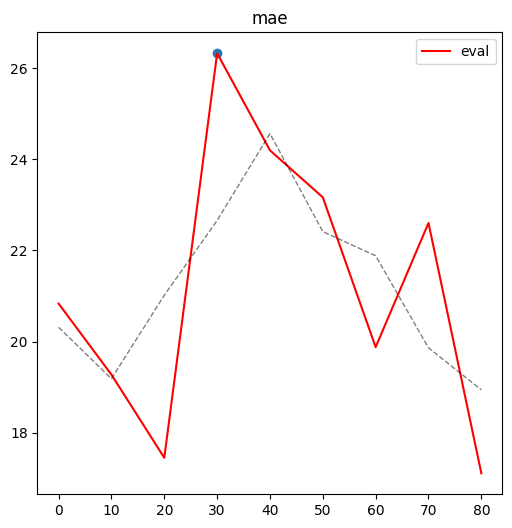

Best  srcc:0.8350428342819214 plcc:0.8754025101661682


In [46]:
path9_1 = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/s_peel9_1.json"
showRes(path9_1)

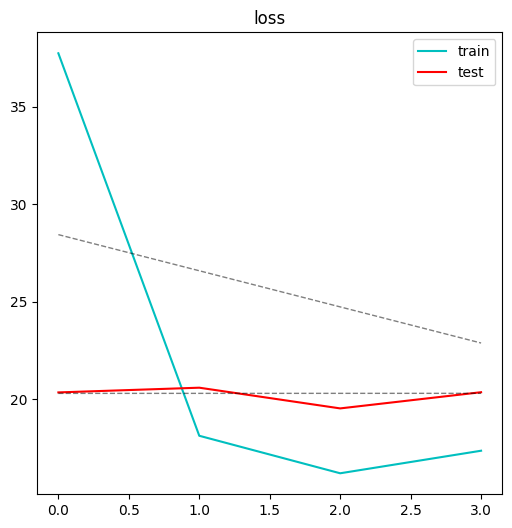

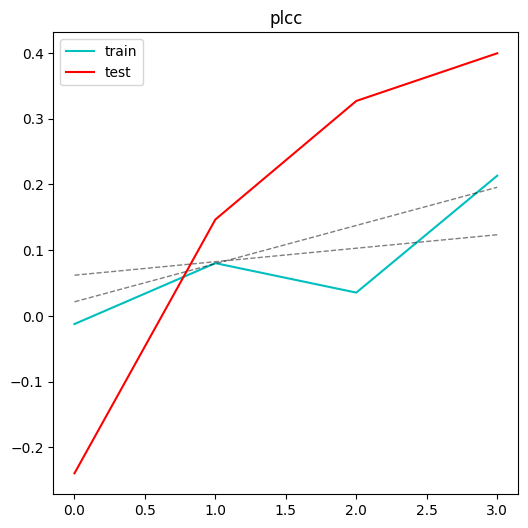

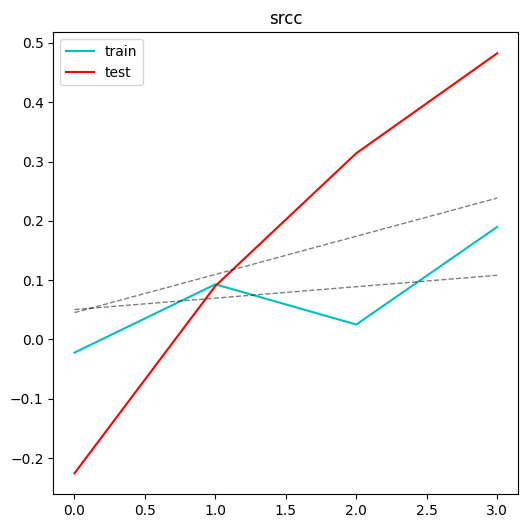

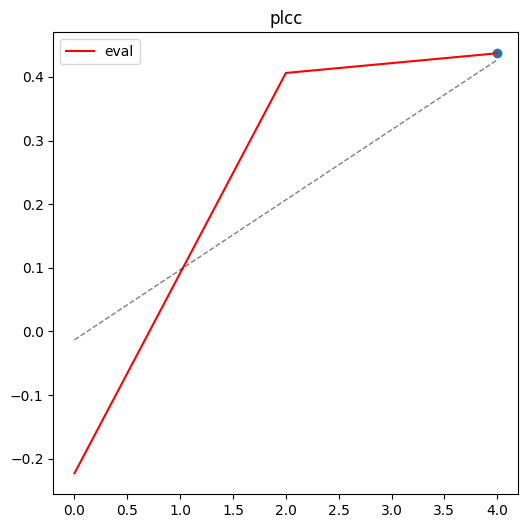

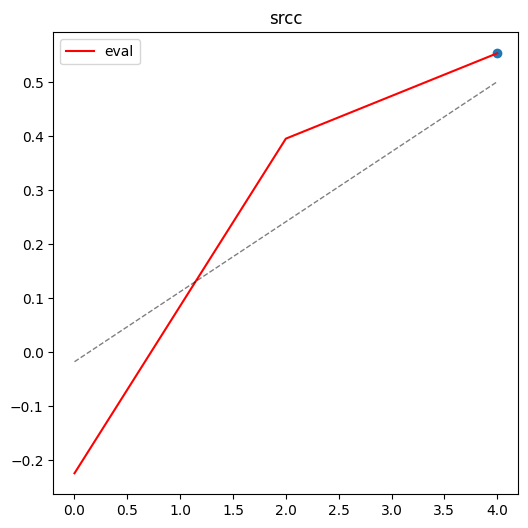

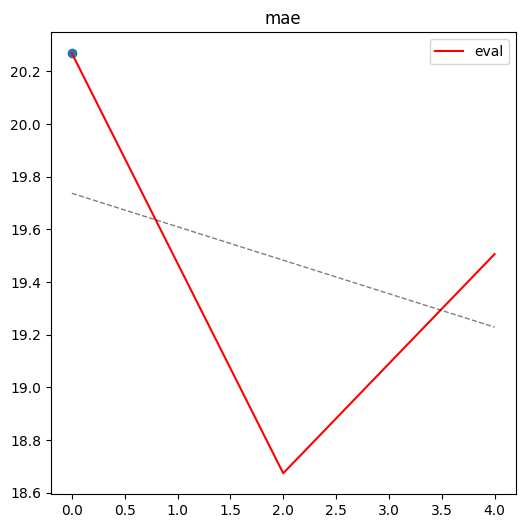

Best  srcc:0.553996205329895 plcc:0.43704745173454285


In [48]:
path = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/Tres_clive_-8334388485563704703.json"
showRes(path)

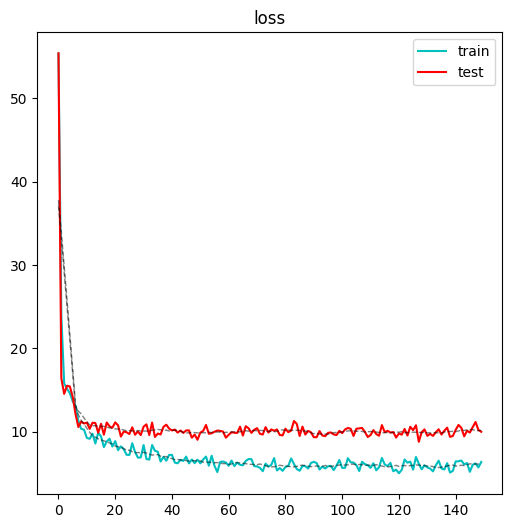

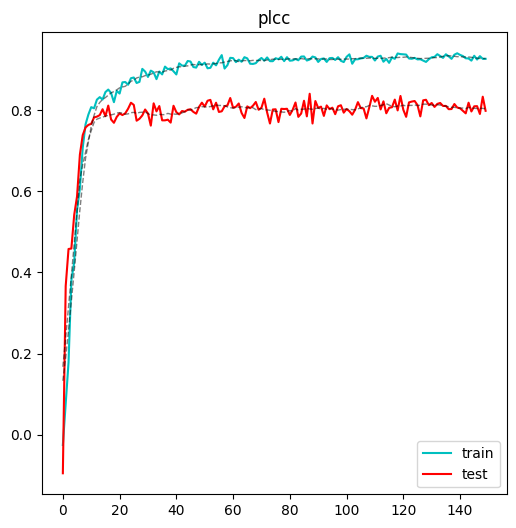

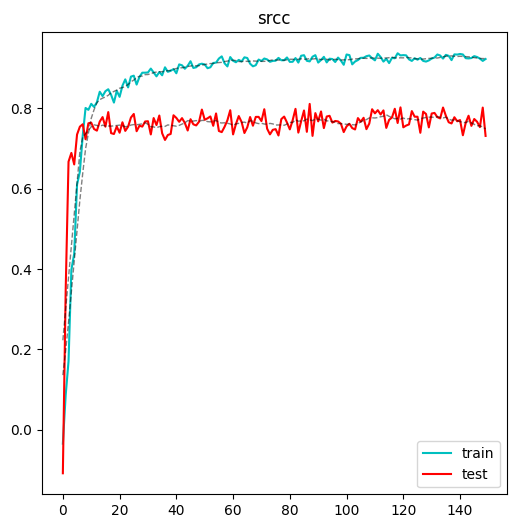

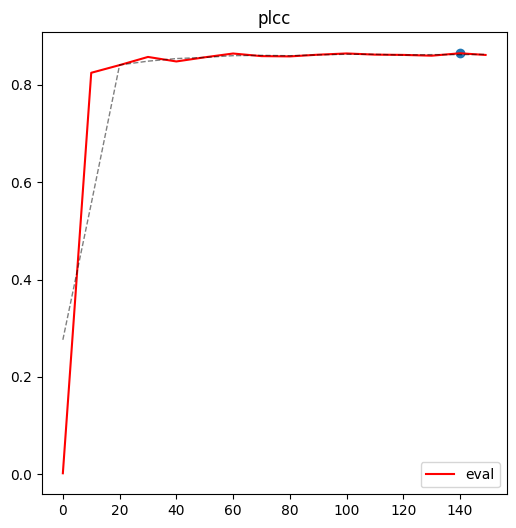

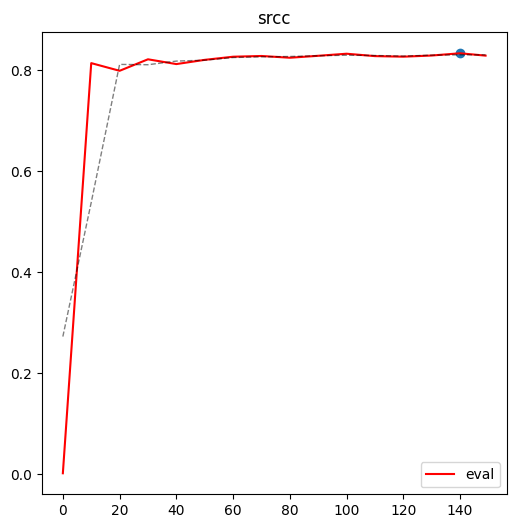

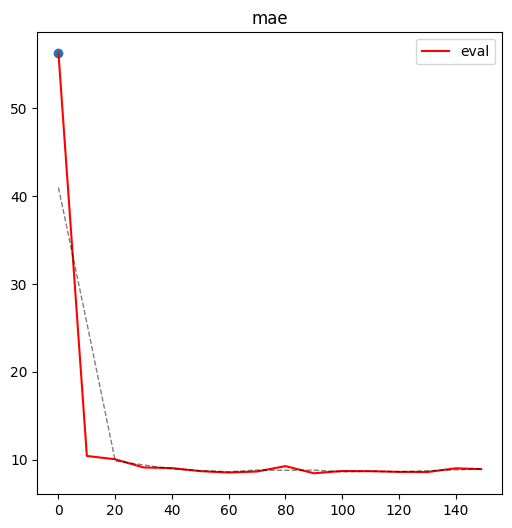

Best  srcc:0.8331597447395325 plcc:0.864800751209259


/tmp/ipykernel_21547/719593463.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred)
/tmp/ipykernel_21547/719593463.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lbl = torch.tensor(lbl)


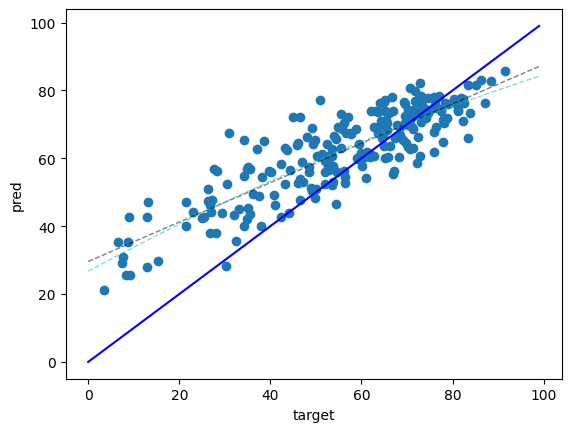

In [56]:
path = "/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/magisterka/checkpoints/Tres_clive_7148494988687791546.json"
showRes(path)